In [5]:
# Logistic Regression을 구현해 보아요!

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from scipy import stats

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam

from imblearn.over_sampling import SMOTE


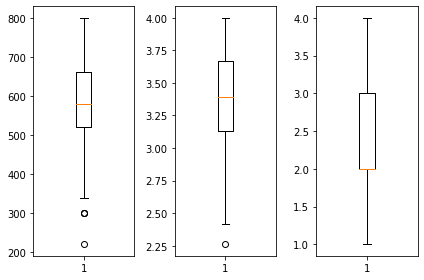

(382, 4)


In [6]:
# Raw Data Loading
df = pd.read_csv(r'C:\Users\lee_0\Desktop\코딩\ML\12.04\admission.csv')
# display(df)  # 400 rows × 4 columns

# 결측치 부터 알아보아요!
# df.info()
# df.isnull().sum()
# 결측치는 존재하지 않아요!

# 이상치도 알아보아야 해요!
# 이상치를 눈으로 확인하려면 boxplot을 그려보면 되요!
fig = plt.figure()
fig_gre = fig.add_subplot(1, 3, 1)
fig_gpa = fig.add_subplot(1, 3, 2)
fig_rank = fig.add_subplot(1, 3, 3)

fig_gre.boxplot(df['gre'])
fig_gpa.boxplot(df['gpa'])
fig_rank.boxplot(df['rank'])

plt.tight_layout()
plt.show()

# 수치상 이상치로 표현이 되지만
# 실제 데이터예요!(이상치가 아니예요!)
# 하지만 우리 학습을 위해 이상치로 판별된 데이터 삭제 진행

zscore_threshold = 2.0  # zscore 임계값 -2이하, 2이상이면 이상치

for col in df.columns:
    outlier = df[col][np.abs(stats.zscore(df[col])) > zscore_threshold]
    df = df.loc[np.isin(df[col], outlier, invert=True)]

print(df.shape)  # (382, 4) 18개의 데이터가 이상치로 제거!

# 정규화를 진행해야 해요!
x_data = df.drop('admit', axis=1, inplace=False).values
t_data = df['admit'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaler.fit(x_data)
x_data_norm = scaler.transform(x_data)

In [7]:
# Model을 구현해 보아요!
# sklearn부터 구현해 보아요!

sklearn_model = linear_model.LogisticRegression()
sklearn_model.fit(x_data,
                  t_data.ravel())

# predict
predict_value = np.array([[600, 3.8, 1]])
result_proba = sklearn_model.predict_proba(predict_value)
print(result_proba)  # [[0.43740782 0.56259218]]

[[0.43740782 0.56259218]]


In [8]:
# Tensorflow Keras로 구현해 보아요!

keras_model = Sequential()

keras_model.add(Flatten(input_shape=(3,)))
keras_model.add(Dense(units=1,
                      activation='sigmoid'))

keras_model.compile(optimizer=SGD(learning_rate=1e-4),
                    loss='binary_crossentropy')

keras_model.fit(x_data_norm,
                t_data,
                epochs=500,
                verbose=0)

# predict
predict_value = np.array([[600, 3.8, 1]])
predict_value_norm = scaler.transform(predict_value)
result = keras_model.predict(predict_value_norm)
print(result)  # [[0.29621825]]

[[0.3464958]]


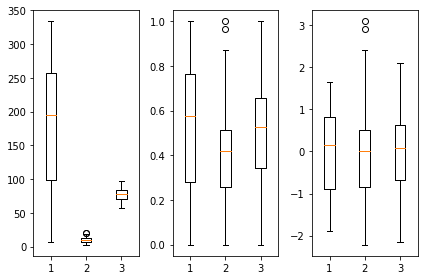

In [9]:
# 데이터 로딩과 전처리!

# Raw Data Loading
df = pd.read_csv(r"C:\Users\lee_0\Desktop\코딩\ML\11.29\ozone.csv")

training_data = df[['Solar.R', 'Wind', 'Temp', 'Ozone']]

# 이렇게 데이터를 가져온 후 당연히 데이터 전처리를 해야 해요!
# 1. 결측치 처리
training_data = training_data.dropna(how='any')

# 2. 이상치 처리!
zscore_threshold = 1.8

outlier = training_data['Ozone'][np.abs(stats.zscore(training_data['Ozone'].values)) > zscore_threshold]

# 이상치를 제거한 결과를 얻어야 해요!
# 내가 가진 DataFrame에서 이상치를 제거하면 되요!
training_data = training_data.loc[np.isin(training_data['Ozone'], outlier, invert=True)]

x_data = training_data.drop('Ozone', axis=1, inplace=False).values
t_data = training_data['Ozone'].values.reshape(-1, 1)

# 3. 정규화 진행(Normalization)
#    모든 feature에 대해 scale을 0과 1로 변경!
#    이렇게 해야 해요!
#    프로그램적으로 이 작업을 하려면 코드작업을 해야해서 좀 그래요!
#    sklearn을 이용하면 이 정규화 작업을 아주 쉽게 할 수 있어요!
scaled_x = MinMaxScaler()
scaled_t = MinMaxScaler()

standard_scaler = StandardScaler()

scaled_x.fit(x_data)
scaled_t.fit(t_data)

standard_scaler.fit(x_data)

# 정규화된 Training Data Set 준비
x_data_norm = scaled_x.transform(x_data)
t_data_norm = scaled_t.transform(t_data)
x_data_stand_norm = standard_scaler.transform(x_data)

fig = plt.figure()
fig_ori = fig.add_subplot(1, 3, 1)
fig_minmax = fig.add_subplot(1, 3, 2)
fig_stand = fig.add_subplot(1, 3, 3)

fig_ori.boxplot(x_data)
fig_minmax.boxplot(x_data_norm)
fig_stand.boxplot(x_data_stand_norm)

plt.tight_layout()
plt.show()

In [10]:
# Imbalanced Data Problem을 해결해 보아요!
# SMOTE 알고리즘을 이용해 보아요!

# 불균형한 데이터가 있어야 해요!
# 유방암 예측 데이터셋을 해 보아요!

# 상당히 많은 feature가 있는데 그 중 4개만 골라서 사용해 보아요!
# feature의 의미는 자세히 알 필요는 없어요! 의학용어

# Raw Data Loading
data = datasets.load_breast_cancer()

df = pd.DataFrame(data.data,
                  columns=data.feature_names)
# display(df)  # 569 rows × 30 columns

df = df[['mean radius', 'mean texture', 'mean area', 'mean symmetry']]
# display(df)  # 569 rows × 4 columns

# target이 1이면 양성종양(좋은거), 0이면 악성종양(나쁜거) 열 지정
df['target'] = data.target
display(df)  # 569 rows × 5 columns

,mean radius,mean texture,mean area,mean symmetry,target
0,17.99,10.38,1001.0,0.2419,0
1,20.57,17.77,1326.0,0.1812,0
2,19.69,21.25,1203.0,0.2069,0
3,11.42,20.38,386.1,0.2597,0
4,20.29,14.34,1297.0,0.1809,0
...,...,...,...,...,...
564,21.56,22.39,1479.0,0.1726,0
565,20.13,28.25,1261.0,0.1752,0
566,16.60,28.08,858.1,0.1590,0
567,20.60,29.33,1265.0,0.2397,0


In [11]:
# 위의 데이터셋은 label이 0 or 1로 구성되어 있어요.
# 이진분류 문제...=> logistic regression으로 나중에 학습이 될꺼예요!

# 학습하기 전에... 데이터부터 정제해야 해요!
# label의 개수를 한번 세어 보아요!
df['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

In [12]:
x_data = df[['mean radius', 'mean texture', 'mean area', 'mean symmetry']]
t_data = df['target']

new_x, new_t = SMOTE(random_state=22).fit_resample(x_data, t_data)

new_t.value_counts()

1    357
0    357
Name: target, dtype: int64

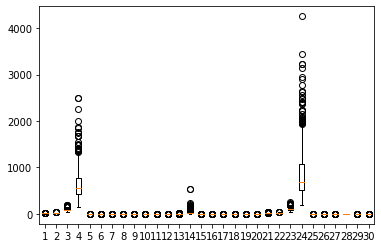

In [13]:
# Raw Data Loading
cancer = datasets.load_breast_cancer()
# cancer안에 data속성에 x_data(독립변수)가 들어있고
#                  target속성에 t_data(종속변수)가 들어있어요!
# shape을 한번 살펴보아요!
# print(cancer.data.shape)  # (569, 30)
# print(cancer.target.shape)  # (569,) 0이면 악성종양, 1이면 양성종양

# x_data, t_data로 변환
x_data = cancer.data
t_data = cancer.target_names

# boxplot을 한번 그려보아요! => 이상치 확인!
plt.boxplot(x_data)
plt.show()

# 결측치는 없구요
# 이상치는 처리하지 않을꺼예요. 수치상으로는 이상치이지만
# 실제로는 이상치가 아니거든요!

# 정규화는 해 줘야 할 거 같아요!
scaler = MinMaxScaler()
scaler.fit(x_data)
x_data_norm = scaler.transform(x_data)

# 데이터를 분리해야 해요!
# Training Data Set, Test Data Set으로 분리하는데 8:2비율로 분리할꺼예요!
# 데이터 분리할때 조심해야 하는 점이 있어요. 분리된 데이터는 데이터의 비대칭이
# 발생하면 안되요!
# 전체 데이터에... 0:1의 비율이 40:60이라면
# Training Data Set의 0과 1의 비율도 4:6 이어야 하고
# Test Data Set의 0과 1의 비율도 4:6 이어야 해요!